In [ ]:
### Toss artificial neuron
# D:/Alice/AK_data/derivatives/sub-03_id-Freddy/ses-000_date-20250527_01/behav/Trial_data.nc
# S3D feature 1:

# trial 16 

In [1]:
import matplotlib.pyplot as plt
from collections import Counter
from ethograph.utils.io import TrialTree
import numpy as np
import matplotlib.pyplot as plt

from ethograph.utils.io import extract_variable_flat
from ethograph.features.preprocessing import z_normalize


paths = [
        r"D:\Alice\AK_data\derivatives\sub-03_id-Freddy\ses-000_date-20250527_01\behav\Trial_data.nc", 
        r"D:\Alice\AK_data\derivatives\sub-03_id-Freddy\ses-000_date-20250527_02\behav\Trial_data.nc", 
        r"D:\Alice\AK_data\derivatives\sub-03_id-Freddy\ses-000_date-20250528_01\behav\Trial_data.nc"
]
        

kwargs={"keypoints": "beakTip", "individuals": "Freddy"},

labels_flat = extract_variable_flat(paths, "labels", {"individuals": "Freddy"})

speed_flat = extract_variable_flat(paths, "speed", {"keypoints": "beakTip", "individuals": "Freddy"})
acc_x_flat = extract_variable_flat(paths, "acceleration", {"keypoints": "beakTip", "individuals": "Freddy", "space": "x"})
acc_y_flat = extract_variable_flat(paths, "acceleration", {"keypoints": "beakTip", "individuals": "Freddy", "space": "y"})

speed_flat = np.nan_to_num(speed_flat, nan=0.0)
acc_x_flat = np.nan_to_num(acc_x_flat, nan=0.0)
acc_y_flat = np.nan_to_num(acc_y_flat, nan=0.0)

speed_flat = (speed_flat - np.mean(speed_flat)) / np.std(speed_flat)
acc_x_flat = (acc_x_flat - np.mean(acc_x_flat)) / np.std(acc_x_flat)
acc_y_flat = (acc_y_flat - np.mean(acc_y_flat)) / np.std(acc_y_flat)

feature_matrix = np.column_stack([speed_flat, acc_x_flat, acc_y_flat])

from itertools import groupby
segments = []
for is_target, group in groupby(
    zip(labels_flat, feature_matrix), 
    key=lambda x: x[0] == 3
):
    if is_target:
        segment_data = np.array([feat_vec for _, feat_vec in group])
        segments.append(segment_data)


: 

In [ ]:
"""Multivariate DTW clustering with interactive visualization."""

from typing import List, Optional, Tuple, Literal
import json
import webbrowser
from pathlib import Path

import numpy as np
from dtaidistance import dtw, dtw_ndim
from sklearn.manifold import MDS, TSNE
from sklearn.cluster import KMeans


def compute_multivariate_dtw_distances(
    sequences: List[np.ndarray],
    method: Literal['independent', 'dependent'] = 'dependent'
) -> np.ndarray:
    """
    Compute pairwise DTW distances for multivariate sequences.
    
    Args:
        sequences: List of 2D arrays (n_timesteps, n_features)
        method: 
            - 'dependent': Features are dependent (true multivariate DTW)
            - 'independent': Average DTW distances across features
    
    Returns:
        Distance matrix
    """
    n = len(sequences)
    dist_matrix = np.zeros((n, n))
    
    print(f"Computing multivariate DTW distances ({method}) for {n} sequences...")
    
    if method == 'dependent':
        # True multivariate DTW using dtw_ndim
        for i in range(n):
            for j in range(i + 1, n):
                distance = dtw_ndim.distance(sequences[i], sequences[j])
                dist_matrix[i, j] = distance
                dist_matrix[j, i] = distance
                
    elif method == 'independent':
        # Independent DTW per feature, then average
        n_features = sequences[0].shape[1]
        
        for i in range(n):
            for j in range(i + 1, n):
                feature_distances = []
                for feat_idx in range(n_features):
                    feat_dist = dtw.distance(
                        sequences[i][:, feat_idx],
                        sequences[j][:, feat_idx]
                    )
                    feature_distances.append(feat_dist)
                dist_matrix[i, j] = np.mean(feature_distances)
                dist_matrix[j, i] = dist_matrix[i, j]
    
    return dist_matrix


def reduce_dimensions(
    dist_matrix: np.ndarray,
    method: str = 'mds',
    n_components: int = 2
) -> np.ndarray:
    """Reduce distance matrix to lower dimensions."""
    print(f"Reducing to {n_components}D using {method}...")
    
    reducers = {
        'mds': lambda: MDS(n_components=n_components, dissimilarity='precomputed', random_state=42),
        'tsne': lambda: TSNE(n_components=n_components, metric='precomputed', init='random', random_state=42)
    }
    
    if method == 'umap':
        try:
            import umap
            reducer = umap.UMAP(n_components=n_components, metric='precomputed', random_state=42)
        except ImportError:
            raise ImportError("Install umap-learn: pip install umap-learn")
    else:
        reducer = reducers.get(method, lambda: None)()
        if reducer is None:
            raise ValueError(f"Unknown reduction method: {method}")
    
    return reducer.fit_transform(dist_matrix)


def cluster_sequences(coords_2d: np.ndarray, n_clusters: int) -> np.ndarray:
    """Perform clustering on 2D coordinates."""
    print(f"Clustering into {n_clusters} clusters...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    return kmeans.fit_predict(coords_2d)


def create_multivariate_dashboard(
    sequences: List[np.ndarray],
    coords_2d: np.ndarray,
    labels: np.ndarray,
    feature_names: List[str],
    method: str,
    output_path: str = "dtw_multivariate.html"
) -> None:
    """Create interactive dashboard for multivariate sequences."""
    
    html_template = """
    <!DOCTYPE html>
    <html>
    <head>
        <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
        <style>
            body {{ 
                font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif;
                margin: 0;
                padding: 20px;
                background: #f5f5f5;
            }}
            h1 {{
                color: #333;
                margin-bottom: 10px;
            }}
            .subtitle {{
                color: #666;
                margin-bottom: 20px;
                font-size: 14px;
            }}
            #container {{
                display: flex;
                gap: 20px;
                background: white;
                padding: 20px;
                border-radius: 8px;
                box-shadow: 0 2px 4px rgba(0,0,0,0.1);
            }}
            #projection-plot {{
                flex: 1;
                min-height: 500px;
            }}
            #traces-plot {{
                flex: 1.5;
                min-height: 500px;
                aspect-ratio: 1 / 1;
            }}
            #info {{
                margin-top: 20px;
                padding: 15px;
                background: white;
                border-radius: 8px;
                box-shadow: 0 2px 4px rgba(0,0,0,0.1);
                font-family: monospace;
            }}
            .stat {{
                display: inline-block;
                margin-right: 20px;
                padding: 5px 10px;
                background: #f0f0f0;
                border-radius: 4px;
            }}
        </style>
    </head>
    <body>
        <h1>Multivariate DTW Clustering</h1>
        <div class="subtitle">
            Method: {method} | Clusters: {n_clusters} | 
            Sequences: {n_sequences} | Features: {feature_names_str}
        </div>
        
        <div id="container">
            <div id="projection-plot"></div>
            <div id="traces-plot"></div>
        </div>
        <div id="info">Click any point to inspect its multivariate traces</div>
        
        <script>
            const sequences = {sequences_json};
            const coords = {coords_json};
            const labels = {labels_json};
            const featureNames = {feature_names_json};
            
            // Color palettes
            const clusterColors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                                 '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'];
            const featureColors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00'];
            
            // Create projection plot
            const projectionData = [...new Set(labels)].map(label => ({{
                x: coords.filter((_, i) => labels[i] === label).map(c => c[0]),
                y: coords.filter((_, i) => labels[i] === label).map(c => c[1]),
                mode: 'markers',
                type: 'scatter',
                name: `Cluster ${{label}}`,
                marker: {{
                    size: 8,
                    color: clusterColors[label % clusterColors.length],
                    line: {{width: 0.5, color: 'white'}}
                }},
                customdata: coords.map((_, i) => i).filter(i => labels[i] === label),
                hovertemplate: 'Index: %{{customdata}}<br>X: %{{x:.3f}}<br>Y: %{{y:.3f}}<extra></extra>'
            }}));
            
            Plotly.newPlot('projection-plot', projectionData, {{
                title: '{method} Projection',
                xaxis: {{title: 'Component 1', zeroline: false}},
                yaxis: {{title: 'Component 2', zeroline: false}},
                hovermode: 'closest',
                showlegend: true,
                legend: {{x: 0, y: 1}}
            }});
            
            // Initialize multivariate traces plot
            function plotMultivariateSequence(idx) {{
                const sequence = sequences[idx];
                const cluster = labels[idx];
                const nFeatures = sequence[0].length;
                const nSamples = sequence.length;
                
                // Create traces for each feature
                const traces = [];
                for (let f = 0; f < nFeatures; f++) {{
                    const values = sequence.map(row => row[f]);
                    traces.push({{
                        y: values,
                        mode: 'lines',
                        type: 'scatter',
                        name: featureNames[f] || `Feature ${{f}}`,
                        line: {{
                            color: featureColors[f % featureColors.length],
                            width: 2
                        }},
                        hovertemplate: '%{{y:.3f}}<extra></extra>'
                    }});
                }}
                
                Plotly.react('traces-plot', traces, {{
                    title: `Sequence ${{idx}} (Cluster ${{cluster}})`,
                    xaxis: {{title: 'Time', zeroline: false}},
                    yaxis: {{title: 'Value', zeroline: false}},
                    showlegend: true
                }});
                
                // Calculate statistics per feature
                let statsHtml = `<span class="stat">Seq: ${{idx}}</span>`;
                statsHtml += `<span class="stat">Cluster: ${{cluster}}</span>`;
                statsHtml += `<span class="stat">Length: ${{nSamples}}</span><br>`;
                
                for (let f = 0; f < nFeatures; f++) {{
                    const values = sequence.map(row => row[f]);
                    const mean = values.reduce((a, b) => a + b, 0) / values.length;
                    const std = Math.sqrt(
                        values.reduce((a, b) => a + Math.pow(b - mean, 2), 0) / values.length
                    );
                    statsHtml += `<span class="stat">${{featureNames[f]}}: μ=${{mean.toFixed(2)}} σ=${{std.toFixed(2)}}</span>`;
                }}
                
                document.getElementById('info').innerHTML = statsHtml;
            }}
            
            // Initialize with first sequence
            plotMultivariateSequence(0);
            
            // Click handler
            document.getElementById('projection-plot').on('plotly_click', function(data) {{
                const idx = data.points[0].customdata;
                plotMultivariateSequence(idx);
            }});
        </script>
    </body>
    </html>
    """
    
    # Convert to JSON
    sequences_json = json.dumps([seq.tolist() for seq in sequences])
    coords_json = json.dumps(coords_2d.tolist())
    labels_json = json.dumps(labels.tolist())
    feature_names_json = json.dumps(feature_names)
    
    # Write HTML
    html_content = html_template.format(
        method=method.upper(),
        n_clusters=len(np.unique(labels)),
        n_sequences=len(sequences),
        feature_names_str=', '.join(feature_names),
        feature_names_json=feature_names_json,
        sequences_json=sequences_json,
        coords_json=coords_json,
        labels_json=labels_json
    )
    
    output_file = Path(output_path)
    output_file.write_text(html_content)
    
    print(f"✓ Multivariate dashboard saved to {output_file}")
    print(f"  Opening in browser...")
    
    webbrowser.open(f"file://{output_file.absolute()}")


def multivariate_dtw_clustering(
    sequences: List[np.ndarray],
    n_clusters: int = 5,
    reduction_method: str = 'mds',
    dtw_method: Literal['dependent', 'independent'] = 'dependent',
    feature_names: Optional[List[str]] = None,
    output_path: str = 'dtw_multivariate.html'
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Perform DTW clustering on multivariate sequences.
    
    Args:
        sequences: List of 2D arrays (n_timesteps, n_features)
        n_clusters: Number of clusters
        reduction_method: 'mds', 'tsne', or 'umap'
        dtw_method: 
            - 'dependent': True multivariate DTW (considers all features jointly)
            - 'independent': Average DTW across features
        feature_names: Optional names for features
        output_path: Output HTML file
        
    Returns:
        labels: Cluster assignments
        coords_2d: 2D coordinates
        dist_matrix: DTW distance matrix
    """
    # Validate and prepare feature names

    


n_features = segments[0].shape[1]
feature_names = [f"Feature {i}" for i in range(n_features)]


n_clusters=4,
reduction_method='tsne'
dtw_method='dependent'  # Use true multivariate DTW
feature_names=['Speed', 'Acc_X', 'Acc_Y']
output_path='multivariate_analysis.html'

# Compute distances and cluster
dist_matrix = compute_multivariate_dtw_distances(segments, dtw_method)
coords_2d = reduce_dimensions(dist_matrix, reduction_method)
labels = cluster_sequences(coords_2d, n_clusters)



In [5]:

# Compute distances and reduce dimensions
dist_matrix = compute_dtw_distances(segments)
coords_2d = reduce_dimensions(dist_matrix, "mds")
labels = cluster_sequences(coords_2d, 4)


Computing DTW distances for 559 sequences...
Reducing to 2D using mds...
Clustering into 4 clusters...


In [9]:
create_interactive_dashboard(
    segments, 
    coords_2d, 
    labels, 
   'tsne',  # or 'mds', 'umap'
    'my_analysis.html'
)

✓ Interactive dashboard saved to my_analysis.html
  Opening in browser...


In [ ]:

def create_interactive_dashboard(
    traces: np.ndarray,
    labels: np.ndarray = None,
    save_html: str = "umap_dashboard.html"
):
    """
    Create a simple interactive HTML dashboard using Plotly only.
    
    Args:
        traces: Array of shape (n_samples, trace_length)
        labels: Optional labels
        save_html: Output HTML filename
    """
    try:
        import umap
    except ImportError:
        raise ImportError("pip install umap-learn")
    
    print("Creating interactive dashboard...")
    
    # Compute UMAP
    embedding = umap.UMAP(n_neighbors=15, min_dist=0.1).fit_transform(traces)
    
    # Create HTML with embedded JavaScript
    html_template = """
    <!DOCTYPE html>
    <html>
    <head>
        <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
        <style>
            body {{ font-family: Arial, sans-serif; margin: 20px; }}
            #container {{ display: flex; gap: 20px; }}
            #umap-plot {{ flex: 1; }}
            #trace-plot {{ flex: 1; }}
            #info {{ margin-top: 20px; padding: 10px; background: #f0f0f0; }}
        </style>
    </head>
    <body>
        <h1>Interactive UMAP Trace Viewer</h1>
        <div id="container">
            <div id="umap-plot"></div>
            <div id="trace-plot"></div>
        </div>
        <div id="info">Click on any point in the UMAP plot to inspect its trace</div>
        
        <script>
            const traces = {traces_json};
            const embedding = {embedding_json};
            const labels = {labels_json};
            
            // Create UMAP plot
            const umapData = labels ? 
                [...new Set(labels)].map(label => ({{
                    x: embedding.filter((_, i) => labels[i] === label).map(e => e[0]),
                    y: embedding.filter((_, i) => labels[i] === label).map(e => e[1]),
                    mode: 'markers',
                    type: 'scatter',
                    name: `Class ${{label}}`,
                    customdata: embedding.map((_, i) => i).filter(i => labels[i] === label)
                }})) :
                [{{
                    x: embedding.map(e => e[0]),
                    y: embedding.map(e => e[1]),
                    mode: 'markers',
                    type: 'scatter',
                    marker: {{color: embedding.map((_, i) => i), colorscale: 'Viridis'}},
                    customdata: embedding.map((_, i) => i)
                }}];
            
            Plotly.newPlot('umap-plot', umapData, {{
                title: 'UMAP Projection',
                xaxis: {{title: 'UMAP 1'}},
                yaxis: {{title: 'UMAP 2'}},
                hovermode: 'closest'
            }});
            
            // Initialize trace plot
            Plotly.newPlot('trace-plot', [{{
                y: traces[0],
                mode: 'lines',
                type: 'scatter'
            }}], {{
                title: 'Trace 0',
                xaxis: {{title: 'Index'}},
                yaxis: {{title: 'Value'}}
            }});
            
            // Click handler
            document.getElementById('umap-plot').on('plotly_click', function(data) {{
                const idx = data.points[0].customdata;
                const trace = traces[idx];
                
                Plotly.react('trace-plot', [{{
                    y: trace,
                    mode: 'lines',
                    type: 'scatter',
                    line: {{color: 'red', width: 2}}
                }}], {{
                    title: `Trace ${{idx}} (mean: ${{(trace.reduce((a,b)=>a+b)/trace.length).toFixed(3)}})`,
                    xaxis: {{title: 'Index'}},
                    yaxis: {{title: 'Value'}}
                }});
                
                document.getElementById('info').innerHTML = 
                    `Selected: Trace ${{idx}} | Length: ${{trace.length}} | ` +
                    `Mean: ${{(trace.reduce((a,b)=>a+b)/trace.length).toFixed(3)}} | ` +
                    `Max: ${{Math.max(...trace).toFixed(3)}} | ` +
                    `Min: ${{Math.min(...trace).toFixed(3)}}`;
            }});
        </script>
    </body>
    </html>
    """
    
    # Prepare data as JSON
    import json
    traces_json = json.dumps(traces.tolist())
    embedding_json = json.dumps(embedding.tolist())
    labels_json = json.dumps(labels.tolist() if labels is not None else None)
    
    # Write HTML
    with open(save_html, 'w') as f:
        f.write(html_template.format(
            traces_json=traces_json,
            embedding_json=embedding_json,
            labels_json=labels_json
        ))
    
    print(f"✓ Interactive dashboard saved to {save_html}")
    print("  Open in your browser to click and explore traces!")
    
    # Also open automatically
    import webbrowser
    webbrowser.open(f"file://{os.path.abspath(save_html)}")



In [ ]:
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS, TSNE
from sklearn.cluster import KMeans, DBSCAN
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import seaborn as sns

def dtw_clustering_with_visualization(
    sequences: List[np.ndarray], 
    n_clusters: int = 5,
    reduction_method: str = 'mds'  # 'mds', 'tsne', or 'umap'
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Cluster sequences using DTW and return 2D coordinates for visualization.
    
    Returns:
        labels: cluster assignments
        coords_2d: 2D coordinates for plotting
        dist_matrix: pairwise DTW distance matrix
    """
    
    # Step 1: Compute pairwise DTW distance matrix
    n = len(sequences)
    dist_matrix = np.zeros((n, n))
    
    print(f"Computing DTW distances for {n} sequences...")
    for i in range(n):
        for j in range(i+1, n):
            distance = dtw.distance(sequences[i], sequences[j])
            dist_matrix[i, j] = distance
            dist_matrix[j, i] = distance
    
    # Step 2: Reduce to 2D for visualization
    print(f"Reducing to 2D using {reduction_method}...")
    if reduction_method == 'mds':
        reducer = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
        coords_2d = reducer.fit_transform(dist_matrix)
    elif reduction_method == 'tsne':
        reducer = TSNE(n_components=2, metric='precomputed', random_state=42)
        coords_2d = reducer.fit_transform(dist_matrix)
    elif reduction_method == 'umap':
        import umap
        reducer = umap.UMAP(n_components=2, metric='precomputed', random_state=42)
        coords_2d = reducer.fit_transform(dist_matrix)
    else:
        raise ValueError(f"Unknown reduction method: {reduction_method}")
    
    # Step 3: Cluster using the distance matrix
    print("Clustering...")
    # Option 1: KMeans on the 2D coordinates
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(coords_2d)
    
    return labels, coords_2d, dist_matrix


def plot_dtw_clusters(
    coords_2d: np.ndarray, 
    labels: np.ndarray,
    sequences: List[np.ndarray] = None,
    title: str = "DTW-based Clustering"
) -> plt.Figure:
    """Create a scatter plot of the clustered sequences in 2D space."""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Colored by clusters
    scatter = ax1.scatter(
        coords_2d[:, 0], 
        coords_2d[:, 1], 
        c=labels, 
        cmap='tab10',
        s=50,
        alpha=0.7,
        edgecolors='black',
        linewidth=0.5
    )
    ax1.set_xlabel('Component 1')
    ax1.set_ylabel('Component 2')
    ax1.set_title(f'{title} - Clusters')
    ax1.grid(True, alpha=0.3)
    
    # Add cluster centers
    for i in range(labels.max() + 1):
        mask = labels == i
        center = coords_2d[mask].mean(axis=0)
        ax1.scatter(center[0], center[1], c='red', s=200, marker='x', linewidths=3)
        ax1.annotate(f'C{i}', center, fontsize=12, fontweight='bold')
    
    plt.colorbar(scatter, ax=ax1, label='Cluster')
    
    # Plot 2: Density/contour plot
    if len(coords_2d) > 10:
        from scipy.stats import gaussian_kde
        xy = coords_2d.T
        z = gaussian_kde(xy)(xy)
        scatter2 = ax2.scatter(
            coords_2d[:, 0], 
            coords_2d[:, 1], 
            c=z, 
            cmap='viridis',
            s=50,
            alpha=0.7,
            edgecolors='black',
            linewidth=0.5
        )
        ax2.set_xlabel('Component 1')
        ax2.set_ylabel('Component 2')
        ax2.set_title(f'{title} - Density')
        ax2.grid(True, alpha=0.3)
        plt.colorbar(scatter2, ax=ax2, label='Density')
    
    plt.tight_layout()
    return fig





# Main execution
if __name__ == "__main__":
    # Generate sample data
    sequences = segments
    
    # Perform DTW clustering with visualization
    labels, coords_2d, dist_matrix = dtw_clustering_with_visualization(
        sequences, 
        n_clusters=4,
        reduction_method='umap'  # Try 'tsne' or 'umap' too
    )

Computing DTW distances for 559 sequences...


In [ ]:
    # Create visualizations
    fig1 = plot_dtw_clusters(coords_2d, labels, sequences)

    
    # Plot some representative sequences
    fig3, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()
    
    for cluster_id in range(min(4, labels.max() + 1)):
        ax = axes[cluster_id]
        mask = labels == cluster_id
        cluster_sequences = [sequences[i] for i, m in enumerate(mask) if m]
        
        # Plot up to 5 sequences from each cluster
        for seq in cluster_sequences[:5]:
            ax.plot(seq, alpha=0.5)
        

        ax.set_title(f'Cluster {cluster_id} (n={len(cluster_sequences)})')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [4]:
labels = np.zeros_like(traces.shape[0])
import os

create_interactive_dashboard(traces, labels, save_html="umap_interactive.html")


Creating interactive dashboard...
✓ Interactive dashboard saved to umap_interactive.html
  Open in your browser to click and explore traces!


In [42]:
for i in range(10):
    plt.plot(segments[i])

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from ethograph.utils.io import TrialTree
from ethograph.utils.labels import plot_motif_segments, load_motif_mapping
from ethograph.features.changepoints import more_changepoint_features

path = r"D:/Alice/AK_data/derivatives/sub-03_id-Freddy/ses-000_date-20250527_01/behav/Trial_data.nc"
dt = TrialTree.load(path)



dt

<xarray.DataTree>
Group: /
├── Group: /trial_1
│       Dimensions:                     (time: 1908, space: 3, keypoints: 3,
│                                        individuals: 1, s3d_dims: 1024, RGB: 3,
│                                        events: 4)
│       Coordinates:
│         * time                        (time) float64 15kB 0.0 0.005 ... 9.53 9.535
│         * space                       (space) <U1 12B 'x' 'y' 'z'
│         * keypoints                   (keypoints) <U8 96B 'beakTip' ... 'pellet'
│         * individuals                 (individuals) <U6 24B 'Freddy'
│       Dimensions without coordinates: s3d_dims, RGB, events
│       Data variables: (12/24)
│           position                    (time, space, keypoints, individuals) float64 137kB ...
│           confidence                  (time, keypoints, individuals) float32 23kB ...
│           velocity                    (time, space, keypoints, individuals) float64 137kB ...
│           speed                       (time, keypoints, individuals) float64 46kB ...
│           acceleration                (time, space, keypoints, individuals) float64 137kB ...
│           pellet_beakTip_dist         (time) float64 15kB ...
│           ...                          ...
│           speed_troughs               (keypoints, individuals, time) int8 6kB ...
│           speed_turning_points        (keypoints, individuals, time) int8 6kB ...
│           angles                      (keypoints, individuals, time) float64 46kB ...
│           angle_rgb                   (keypoints, individuals, time, RGB) float64 137kB ...
│           labels                      (time, individuals) float64 15kB ...
│           boundary_events             (events) float64 32B ...
│       Attributes: (12/17)
│           source_software:  DeepLabCut
│           ds_type:          poses
│           fps:              200.0
│           time_unit:        seconds
│           source_file:      D:/Alice/AK_data/rawdata/sub-03_id-Freddy/ses-000_date-...
│           trial:            1
│           ...               ...
│           cam2_file:        2025-05-27_001_Freddy-cam-2.mp4
│           dlc1_file:        2025-05-27_001_Freddy-cam-1DLC_resnet50_Felix_cross_Ses...
│           dlc2_file:        2025-05-27_001_Freddy-cam-2DLC_resnet50_Felix_cross_Ses...
│           poscat:           1
│           num_pellets:      1
│           human_verified:   1
├── Group: /trial_2
│       Dimensions:                     (time: 1081, space: 3, keypoints: 3,
│                                        individuals: 1, s3d_dims: 1024, RGB: 3,
│                                        events: 4)
│       Coordinates:
│         * time                        (time) float64 9kB 0.0 0.005 0.01 ... 5.395 5.4
│         * space                       (space) <U1 12B 'x' 'y' 'z'
│         * keypoints                   (keypoints) <U8 96B 'beakTip' ... 'pellet'
│         * individuals                 (individuals) <U6 24B 'Freddy'
│       Dimensions without coordinates: s3d_dims, RGB, events
│       Data variables: (12/24)
│           position                    (time, space, keypoints, individuals) float64 78kB ...
│           confidence                  (time, keypoints, individuals) float32 13kB ...
│           velocity                    (time, space, keypoints, individuals) float64 78kB ...
│           speed                       (time, keypoints, individuals) float64 26kB ...
│           acceleration                (time, space, keypoints, individuals) float64 78kB ...
│           pellet_beakTip_dist         (time) float64 9kB ...
│           ...                          ...
│           speed_troughs               (keypoints, individuals, time) int8 3kB ...
│           speed_turning_points        (keypoints, individuals, time) int8 3kB ...
│           angles                      (keypoints, individuals, time) float64 26kB ...
│           angle_rgb                   (keypoints, individuals, time, RGB) float64 78kB ...
│           l

In [ ]:
x = dt[""]

In [17]:
file.shape

(1081,)

In [22]:
import numpy as np

file = np.load(r"D:\Akseli\Code\MovFormer\TEMP\feature_mask_backbone_feats_1759910793.548359.npy")
data = file.squeeze()
data.shape

(192, 982)

## explore s3d

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ethograph.utils.io import TrialTree
from ethograph.utils.labels import plot_motif_segments, load_motif_mapping
from ethograph.features.changepoints import more_changepoint_features

path = r"D:/Alice/AK_data/derivatives/sub-03_id-Freddy/ses-000_date-20250527_01/behav/Trial_data.nc"
dt = TrialTree.load(path)
ds = dt.trial(16).isel(time=slice(110, 430))
motif_mappings = load_motif_mapping(r"D:\Akseli\Code\MovFormer\configs_global\mapping.txt")

# Create subplot grid: 30 dimensions × 5 trials
start = 170
end = start + 30
n_trials = 3
trials = [16, 48, 49]
fig, axes = plt.subplots(30, n_trials, figsize=(20, 3*30), sharex=True)

for dim_idx in range(start, end):
    ax_num = dim_idx - start  # Adjust index for subplot grid
    for trial_idx in range(n_trials):
        trial_num = trials[trial_idx]
        ds = dt.trial(trial_num)
        time = ds.time.values
        labels = ds.labels.squeeze().values
        
        # Plot S3D feature for current dimension
        ax = axes[ax_num, trial_idx]
        feature_data = ds.s3d.sel(s3d_dims=dim_idx).squeeze()
        ax.plot(time, feature_data)
        plot_motif_segments(ax, time, labels, motif_mappings, is_main=True)
        
        # Format subplot
        if trial_idx == 0:
            ax.set_ylabel(f'Dim {dim_idx}', fontsize=8)
        if dim_idx == 0:
            ax.set_title(f'Trial {trial_num}', fontsize=10)

        ax.tick_params(labelsize=6)
        ax.grid(True, alpha=0.3)

plt.suptitle('S3D Features: 30 Dimensions × 5 Trials', fontsize=14, y=1.001)
plt.tight_layout()
plt.show()

## Toss input features

In [ ]:
labels

# Find indices where labels change (transitions)

Transition indices: [ 13  37  78 112 184 216 247 269 283 295]


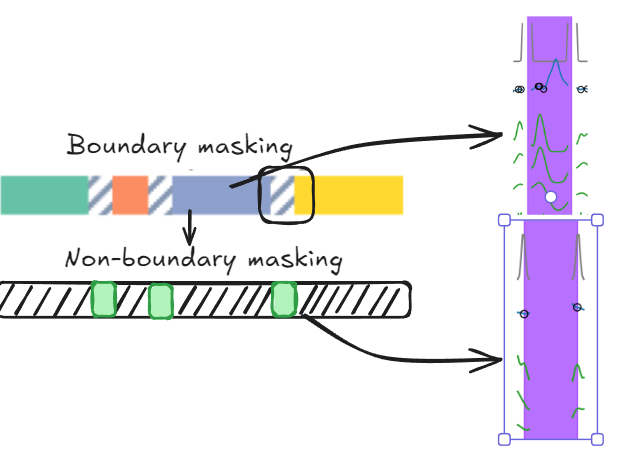


maybe put this on the right side of the feature engineering post

Running Cohen's d feature selection across all trials...

Processing trial 544/544...


In [ ]:


# Analyze across trials
aggregated_scores, per_trial_scores, aggregated_pvals = analyze_across_trials(
    trial_data
)

# Check consistency across trials
feature_consistency = np.std(per_trial_scores, axis=0)  # low std = consistent

In [ ]:
from ethograph.utils.labels import load_mapping

motif_mappings = load_motif_mapping(r"D:\Akseli\Code\MovFormer\configs_global\mapping.txt")

top_features = [482, 763, 332, 781, 114, 93, 686, 379, 115, 199, 480, 335, 265, 829, 331, 260, 635, 213,
                504, 924, 182, 363, 104, 279, 485]


for feat in [837, 327, 192, 332, 763, 589, 482, 213, 650, 199,  24, 645, 568,
        21, 733, 608, 781,  93, 504, 458, 460,  97, 886, 330, 629, 218,
       248, 671, 480, 829, 784, 265, 585, 731, 114, 115, 644, 780, 707,
       139, 260, 210,  96, 363, 749, 242, 765, 640,   4, 326]:

    
    for trial in dt.trials[:20]:
        ds = dt.trial(trial)
        labels = ds.labels.values.squeeze()
        if np.all(labels == 0):
            continue
        
        s3d = ds.s3d.values
        time = ds.time.values
        
        feature_data = s3d[:, feat]
        
        plt.figure(figsize=(12, 2))
        plt.plot(time, feature_data, label=f'Feature {feat}')
        plot_motif_segments(plt.gca(), time, labels, motif_mappings, is_main=True)
        plt.title(f'Trial {trial} - Feature {feat}')
        plt.xlabel('Time')
        plt.ylabel('Feature Value')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

    
    

In [12]:
[2 ** (i // 2) for i in range(10)]

[1, 1, 2, 2, 4, 4, 8, 8, 16, 16]

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from ethograph.utils.io import TrialTree
from ethograph.utils.labels import plot_motif_segments, load_motif_mapping
from ethograph.features.changepoints import more_changepoint_features, merge_changepoints
from ethograph.utils.dataset import get_boundary_seq, get_boundary_binary, create_boundary_window_mask

path = r"D:\Alice\AK_data\derivatives\sub-03_id-Freddy\ses-000_date-20250527_01\behav\Trial_data.nc"
dt = TrialTree.load(path)

ds

<xarray.Dataset> Size: 3MB
Dimensions:                     (time: 330, space: 3, keypoints: 3,
                                 individuals: 1, s3d_dims: 1024, RGB: 3,
                                 events: 4)
Coordinates:
  * time                        (time) float64 3kB 3.0 3.005 3.01 ... 4.64 4.645
  * space                       (space) <U1 12B 'x' 'y' 'z'
  * keypoints                   (keypoints) <U8 96B 'beakTip' ... 'pellet'
  * individuals                 (individuals) <U6 24B 'Freddy'
Dimensions without coordinates: s3d_dims, RGB, events
Data variables: (12/24)
    position                    (time, space, keypoints, individuals) float64 24kB ...
    confidence                  (time, keypoints, individuals) float32 4kB ...
    velocity                    (time, space, keypoints, individuals) float64 24kB ...
    speed                       (time, keypoints, individuals) float64 8kB ...
    acceleration                (time, space, keypoints, individuals) float64 24kB ...
    pellet_beakTip_dist         (time) float64 3kB ...
    ...                          ...
    speed_troughs               (keypoints, individuals, time) int8 990B ...
    speed_turning_points        (keypoints, individuals, time) int8 990B ...
    angles                      (keypoints, individuals, time) float64 8kB ...
    angle_rgb                   (keypoints, individuals, time, RGB) float64 24kB ...
    labels                      (time, individuals) float64 3kB ...
    boundary_events             (events) float64 32B ...
Attributes: (12/17)
    source_software:  DeepLabCut
    ds_type:          poses
    fps:              200.0
    time_unit:        seconds
    source_file:      D:/Alice/AK_data/rawdata/sub-03_id-Freddy/ses-000_date-...
    trial:            18
    ...               ...
    cam2_file:        2025-05-27_018_Freddy-cam-2.mp4
    dlc1_file:        2025-05-27_018_Freddy-cam-1DLC_resnet50_Felix_cross_Ses...
    dlc2_file:        2025-05-27_018_Freddy-cam-2DLC_resnet50_Felix_cross_Ses...
    poscat:           1
    num_pellets:      1
    human_verified:   1

In [9]:
ds.boundary_events.values


start 

array([ 174., 1012.,  648.,  970.])


Window size 5
  Number of boundary segments: 20


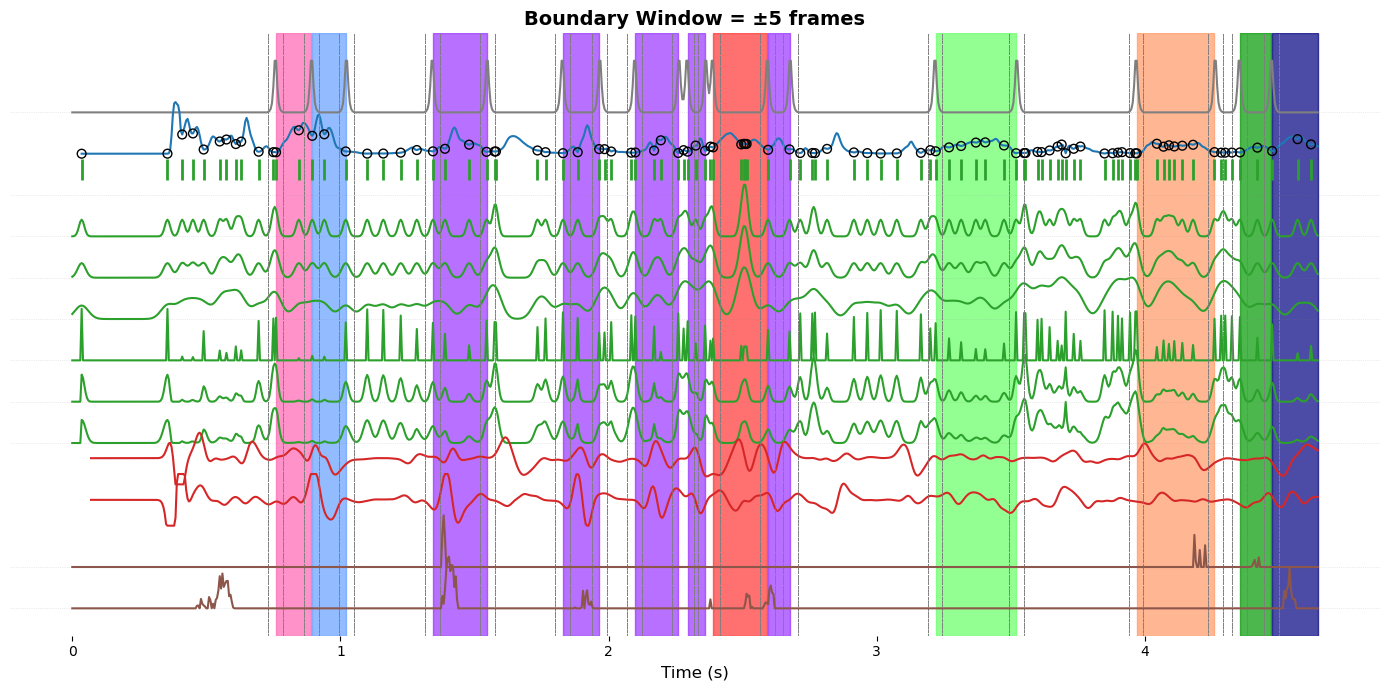


Window size 5
  Number of boundary segments: 18


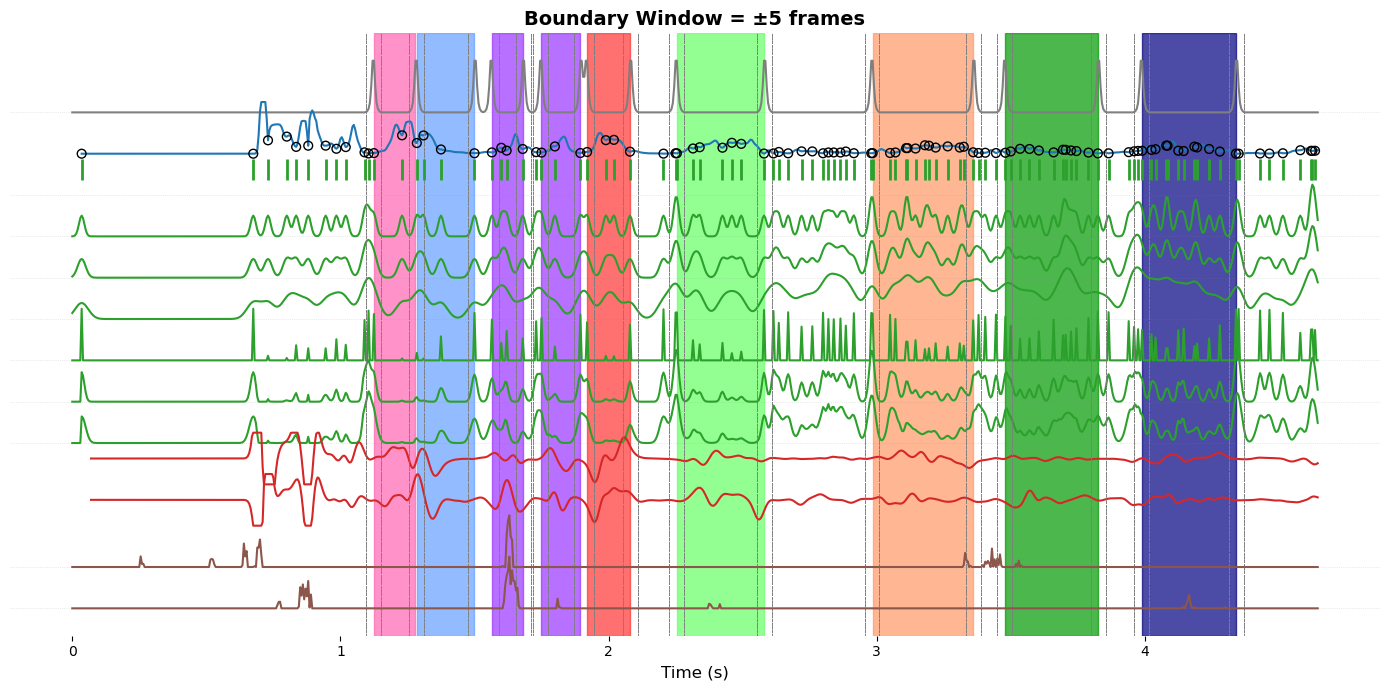


Window size 5
  Number of boundary segments: 15



Window size 5
  Number of boundary segments: 16


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ethograph.utils.io import TrialTree
from ethograph.utils.labels import plot_motif_segments, load_motif_mapping
from ethograph.features.changepoints import more_changepoint_features, merge_changepoints
from ethograph.utils.dataset import get_boundary_seq, get_boundary_binary, create_boundary_window_mask

path = r"D:\Alice\AK_data\derivatives\sub-03_id-Freddy\ses-000_date-20250527_01\behav\Trial_data.nc"
dt = TrialTree.load(path)

for num in [16, 18, 48, 49]:
    ds = dt.trial(num).isel(time=slice(0, 930))
    motif_mappings = load_motif_mapping(r"D:\Akseli\Code\MovFormer\configs_global\mapping.txt")

    kwargs = {"keypoints": "beakTip", "individuals": "Freddy"}
    labels = ds.labels.sel(individuals="Freddy").values
    time = ds.time.values

    speed = ds.speed.sel(**kwargs)
    acc = ds.acceleration.sel(**kwargs)
    s3d = ds.s3d

    cp_ds, _ = merge_changepoints(ds.sel(**kwargs))

    cp_binary = cp_ds["changepoints"].squeeze().values
    cp_idxs = np.where(cp_binary)[0]

    cp_feats = more_changepoint_features(
        cp_binary,
        targ_feat_vals=speed.values,
        sigmas=[2.0, 3.0, 5.0]
    )

    # Group colors by feature type
    feature_colors = {
        "boundary": "#7f7f7f",      # gray
        "speed": "#1f77b4",           # blue
        "changepoints": "#2ca02c",    # green
        "turning_points": "#ff7f0e",  # orange
        "acceleration": "#d62728",    # red
        "s3d": "#8c564b"              # brown
    }

    shift_factor = -0.8
    event_seq_raw = np.where(labels == 0, -100, labels)

    # Get binary boundaries
    boundary_binary = get_boundary_binary(event_seq_raw)

    # For visualization: show smoothed boundary
    boundary_show = get_boundary_seq(event_seq_raw, 1)
    boundary_show /= boundary_show.max()

    datasets = [
        ("Boundary (smoothed for viz)", boundary_show, "boundary"),
        ("Speed", speed, "speed"),
        ("Changepoint Binary", cp_feats[:, 0], "changepoints"),
        ("Changepoint Gaussian ($\\sigma=3$)", cp_feats[:, 1], "changepoints"),
        ("Changepoint Gaussian ($\\sigma=5$)", cp_feats[:, 2], "changepoints"),
        ("Changepoint Gaussian ($\\sigma=7$)", cp_feats[:, 3], "changepoints"),
        ("Changepoint Weighted Gaussian ($\\sigma=3$)", cp_feats[:, 4], "changepoints"),
        ("Changepoint Weighted Gaussian ($\\sigma=5$)", cp_feats[:, 5], "changepoints"),
        ("Changepoint Weighted Gaussian ($\\sigma=7$)", cp_feats[:, 6], "changepoints"),
        ("Accel. x", acc.sel(space="x"), "acceleration"),
        ("Accel. y", acc.sel(space="y"), "acceleration"),
        ("S3D 1", s3d.sel(s3d_dims=1), "s3d"),
        ("S3D 112", s3d.sel(s3d_dims=191), "s3d"),
    ]

    # Visualize different window sizes
    for window_size in [5]: # , 7]: # [3, 5, 7]

        # Create mask: keep only frames within window of boundaries
        mask = create_boundary_window_mask(boundary_binary, window_size)

        fig, ax = plt.subplots(figsize=(14, 7))

        for idx, (label, data, group) in enumerate(datasets):
            if isinstance(data, np.ndarray):
                values = data
            else:
                values = data.values

            # Find segments where mask is True
            segments = []
            in_segment = False
            for i, val in enumerate(mask):
                if val and not in_segment:
                    start = i
                    in_segment = True
                elif not val and in_segment:
                    end = i
                    segments.append((start, end))
                    in_segment = False

            # Handle case where mask ends with True
            if in_segment:
                segments.append((start, len(mask)))

            # Draw vertical lines at segment boundaries
            for seg in segments:
                ax.axvline(time[seg[0]], color='gray', linestyle='--', alpha=0.5, linewidth=0.5)
                ax.axvline(time[seg[1]-1], color='gray', linestyle='--', alpha=0.5, linewidth=0.5)

            # # Mask out features outside window
            # if label != "Boundary (smoothed for viz)":
            #     values = np.where(mask, values, np.nan)

            normalized = (values - np.nanmin(values)) / (np.nanmax(values) - np.nanmin(values) + 1e-8)
            shifted = normalized + idx * shift_factor

            if "Binary" in label:
                pulse_indices = np.where(values > 0.5)[0]
                ax.vlines(time[pulse_indices], shifted.min()+0.3, shifted.max()-0.3,
                        color=feature_colors[group], label=label, linewidth=2, zorder=3)
            else:
                ax.plot(time, shifted, color=feature_colors[group], label=label, zorder=2)
                if 'Speed' == label:
                    ax.scatter(time[cp_idxs], shifted[cp_idxs], s=40, marker='o',
                            edgecolor='black', facecolor='none', zorder=4)

            ax.axhline(y=shifted.min(), color='gray', linestyle=':', alpha=0.3, linewidth=0.5, zorder=1)


        ylim = ax.get_ylim()
        plot_motif_segments(ax, time, labels, motif_mappings, is_main=True)

        for spine in ax.spines.values():
            spine.set_visible(False)

        ax.set_xlabel('Time (s)', fontsize=12)
        ax.set_yticks([])
        ax.set_title(f'Boundary Window = ±{window_size} frames',
                    fontsize=14, fontweight='bold')

        plt.tight_layout()
        plt.show()

        print(f"\nWindow size {window_size}")
        print(f"  Number of boundary segments: {len(segments)}")

In [ ]:
temporal_rid

294

In [82]:
len(labels)

320

In [81]:
len(mask)

320

In [ ]:
from itertools import groupby


# Handle case where mask ends with True
if in_segment:
    segments.append((start, len(mask)))

print(segments)

[(11, 15), (35, 39), (76, 80), (110, 114), (182, 186), (214, 218), (245, 249), (267, 271), (281, 285), (293, 297)]
